In [1]:
import pandas as pd

df01 = pd.read_csv(r'data\origin\ex\0000001.csv',sep=';', names=['Num','X','Y'],dtype={'Num':'str'})
df01

,Num,X,Y
0,6a,-32.440171,2.175778
1,7,-41.465813,1.644844
2,7b,-56.411206,1.329609
3,8,70.667389,5.257387
4,7a,55.487704,4.691141
5,6,7.492313,3.028990
6,4,-28.701654,1.783774
7,3,-40.871366,2.022232
8,1,0.000022,77.232177
9,2,66.775321,5.272296


In [2]:
df02 = pd.read_csv(r'data\origin\ex\0000002.csv',sep=';', names=['Num','X','Y'],dtype={'Num':'str'})
df02

,Num,X,Y
0,9,-9.982620,2.334459
1,9a,-21.778532,2.089345
2,12,-70.229242,0.342660
3,13,95.745037,6.060164
4,11,43.762437,4.303287
5,9b,21.534892,3.505017
6,8,-9.815163,2.580701
7,7a,-24.994734,2.014322
8,6,-72.991093,0.352641
9,6a,48.042324,4.852631


Дополнительный шаг - выборка номер одинаковых номеров пунктов.
Сортирую номера и записи в таблицы, надеюсь, что принцип сортировки и в сете и в дф одинаковые, но лучше будет убедиться.

In [3]:
inter = sorted(set(list(zip(*df01['Num'].iteritems()))[1]).intersection(set(list(zip(*df02['Num'].iteritems()))[1])))

df01_com = df01.loc[df01['Num'].isin(inter)].sort_values(by='Num')
df02_com = df02.loc[df02['Num'].isin(inter)].sort_values(by='Num')

In [4]:
inter

['6', '6a', '7', '7a', '7b', '8']

Создаю по два набора точек - mp01,mp02 - все точки, включая стоянки. mp01_c, mp02_c - набор общих точек.

In [5]:
from shapely.geometry import MultiPoint

mp01 = MultiPoint([i[2:4] for i in df01.itertuples()])
mp01_c = MultiPoint([i[2:4] for i in df01_com.itertuples()])
mp02 = MultiPoint([i[2:4] for i in df02.itertuples()])
mp02_c = MultiPoint([i[2:4] for i in df02_com.itertuples()])

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline  

def plp(z,n):
    try:
        for mp in z:        
            x = [i.x for i in mp.geoms]
            y = [i.y for i in mp.geoms]
    except AttributeError:
        x = [i.x for i in z.geoms]
        y = [i.y for i in z.geoms]
            
    plt.figure(n)
    plt.plot(x,y,'ro')
    plt.plot(x,y,'ro')

        
    plt.show()

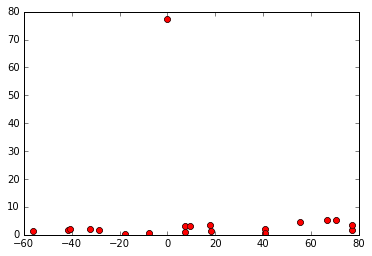

In [16]:
plp(mp01,0)

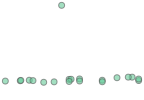

In [13]:
mp01

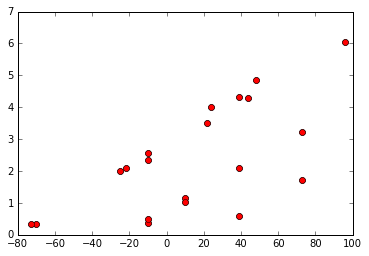

In [15]:
plp(mp02,2)

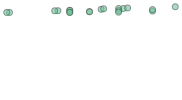

In [14]:
mp02

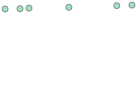

In [19]:
mp01_c

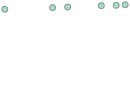

In [18]:
mp02_c

In [50]:
from shapely import affinity
from scipy.optimize import minimize,rosen_der

def mov(x,y,angle,geom):
    geom_r = affinity.rotate(geom,angle,origin=(0,0))
    geom_t = affinity.translate(geom_r,x,y)
    return geom_t

def calc_dist(geom1,geom2):
    dist = 0
    geom_list = zip(geom1,geom2)
    for item in geom_list:
        dist+=item[0].distance(item[1])
    return dist

def fun1(x0,geom1, geom2):
    x,y,angle = x0
    n_geom = mov(x,y,angle,geom2)
    return calc_dist(geom1,n_geom)

In [51]:
x0 = (0,0,0)

In [52]:
re = minimize(fun1,x0,args=(mp01_c[0:-2],mp02_c[0:-2]),method='BFGS')
re

      fun: 321.0635109640691
 hess_inv: array([[  1.00000000e+00,  -3.10859103e-05,   2.10373898e-02],
       [ -3.10859103e-05,   9.99694324e-01,   1.48267907e-01],
       [  2.10373898e-02,   1.48267907e-01,  -5.96837388e+01]])
      jac: array([ 0.00372696,  0.01065826, -0.18746948])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 92
      nit: 1
     njev: 16
   status: 2
  success: False
        x: array([  0.        ,  -0.015625  ,  10.57421875])

In [53]:
zz = mov(*re.x,mp02_c)
for i in zz:
    print(i.x,i.y)

-71.81627239982357 -13.063498449861758
37.56115566903934 11.393136038344652
-10.122063848712585 0.7200794101683128
46.33596901635861 13.57080007950274
-24.93992071475617 -2.622269485962028
22.927423161932634 8.340180079285538


In [54]:
zz = mov(*re.x,mp02)
for i in zz:
    print(i.x,i.y)

-10.241489996349594 0.4472888297799238
-21.79210279273905 -1.958318870998475
-69.09949138988247 -12.566484703012508
93.00700154514043 23.511705884976273
42.229572235633874 12.24538614397204
20.52598476759942 7.381717124732672
-10.122063848712585 0.7200794101683128
-24.93992071475617 -2.622269485962028
-71.81627239982357 -13.063498449861758
46.33596901635861 13.57080007950274
37.56115566903934 11.393136038344652
22.927423161932634 8.340180079285538
71.43492937131462 15.06790347811666
71.1216462188279 16.550666098016585
38.0098529981014 9.225329522459061
38.23040299222132 7.718055392747198
-9.749813992151541 -1.453965587160803
9.434983309901599 2.9062620326955813
-9.890402176513456 -1.3721834545538074
9.566941439861393 2.8246670099521


In [55]:
re2 = minimize(fun1,x0,args=(mp01_c,zz),method='BFGS')
re

      fun: 321.0635109640691
 hess_inv: array([[  1.00000000e+00,  -3.10859103e-05,   2.10373898e-02],
       [ -3.10859103e-05,   9.99694324e-01,   1.48267907e-01],
       [  2.10373898e-02,   1.48267907e-01,  -5.96837388e+01]])
      jac: array([ 0.00372696,  0.01065826, -0.18746948])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 92
      nit: 1
     njev: 16
   status: 2
  success: False
        x: array([  0.        ,  -0.015625  ,  10.57421875])

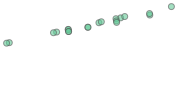

In [56]:
mp_moved = mov(*re.x,mp02)
mp_moved

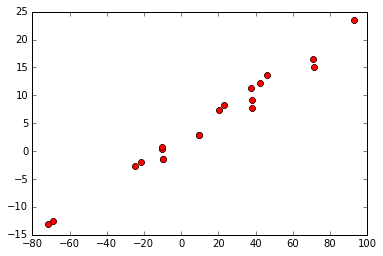

In [74]:
plp(mp_moved,10)

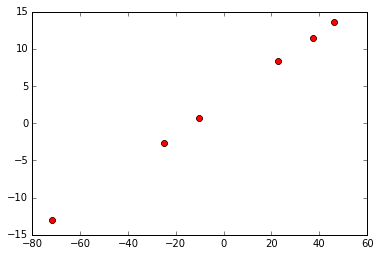

In [72]:
plp(mov(*re.x,mp02_c),6)

In [73]:
for i in mp02_c:
    print(i.x,i.y)

-72.99109279585439 0.3526406616437741
39.016903760714094 4.322205982022502
-9.815162769011282 2.58070094245151
48.04232446294023 4.8526313813704425
-24.99473435964963 2.014322472959673
24.071435954053158 4.006517500180925


Считаем расстояния от стоянки 99002 до всех точек.  
До сдвижки, после сдвижки, значение сдвижки.

In [75]:
dist_do = [mp02[-1].distance(i) for i in mp02]
dist_po = [mp_moved[-1].distance(i) for i in mp_moved]
od = zip(dist_do,dist_po)
od = [[i[0],i[1],i[0]-i[1]] for i in od]
df_od = pd.DataFrame.from_records(od,columns=('Before','After','Diff'))
df_od

,Before,After,Diff
0,19.950586,19.950586,0.000000e+00
1,31.721706,31.721706,3.552714e-15
2,80.157939,80.157939,0.000000e+00
3,85.966256,85.966256,0.000000e+00
4,33.994079,33.994079,7.105427e-15
5,11.868755,11.868755,-3.552714e-15
6,19.801167,19.801167,-3.552714e-15
7,34.934119,34.934119,0.000000e+00
8,82.919607,82.919607,0.000000e+00
9,38.307189,38.307189,7.105427e-15


Расстояние между всеми точками:

In [115]:
all_l = []
for origin in mp02:
    nap = []
    for p in mp02:
        nap.append(origin.distance(p))
    all_l.append(nap)

all_2 = []
for origin in mp_moved:
    nap = []
    for p in mp_moved:
        nap.append(origin.distance(p))
    all_2.append(nap)

all_a = [list(zip(i[0],i[1])) for i in list(zip(all_l,all_2))]
all_a

[[(0.0, 0.0),
  (25.448999927896534, 25.44899992789563),
  (25.653840135347185, 25.65384013534917),
  (50.54347325026157, 50.54347325026195),
  (75.83284635143167, 75.83284635143289),
  (100.59726951866018, 100.59726951866027),
  (125.70694269629573, 125.70694269629684),
  (150.74302307917762, 150.74302307917912),
  (49.995183487412575, 49.99518348741111),
  (100.22227020483042, 100.22227020482927),
  (126.25779385828079, 126.25779385827937),
  (75.17798215974038, 75.17798215973897)],
 [(25.448999927896534, 25.44899992789563),
  (0.0, 0.0),
  (49.89394579906532, 49.89394579906614),
  (75.5944253135779, 75.59442531357728),
  (100.48225573766805, 100.4822557376682),
  (125.56805138887978, 125.56805138887886),
  (150.43777333369513, 150.4377733336952),
  (175.67919446923693, 175.6791944692374),
  (25.737078402373907, 25.73707840237333),
  (75.57195612050664, 75.57195612050648),
  (101.28748745985247, 101.28748745985204),
  (50.12486930935582, 50.124869309355354)],
 [(25.653840135347185, 2

Таблица с координатам сдвинутого 99002:

In [76]:
df2_nums = list(zip(*df02['Num'].iteritems()))[1]
al = list(zip(df2_nums,mp_moved))
mov_stag = [[i[0],i[1].x,i[1].y,al[-1][1].distance(i[1])] for i in al]
mov_df = pd.DataFrame.from_records(mov_stag,columns=('Num','X','Y','Dist'))
mov_df



,Num,X,Y,Dist
0,000009,-10.241490,0.447289,19.950586
1,00009a,-21.792103,-1.958319,31.721706
2,000012,-69.099491,-12.566485,80.157939
3,000013,93.007002,23.511706,85.966256
4,000011,42.229572,12.245386,33.994079
5,00009b,20.525985,7.381717,11.868755
6,000008,-10.122064,0.720079,19.801167
7,00007a,-24.939921,-2.622269,34.934119
8,000006,-71.816272,-13.063498,82.919607
9,00006a,46.335969,13.570800,38.307189


Координаты 99001:

In [118]:
df01

,Num,X,Y,Dist
0,597,-14227.1757,-336.1428,NaN
1,596,-14205.7968,-321.8240,NaN
2,598,-14252.2691,-340.0457,NaN
3,599,-14274.3920,-354.6250,NaN
4,600,-14299.9163,-358.6838,NaN
5,601,-14321.1641,-372.9319,NaN
6,602,-14346.5794,-376.9875,NaN
7,603,-14367.7186,-391.1576,NaN
8,595,-14180.5512,-317.8627,NaN
9,593,-14133.8874,-299.5836,NaN


Оригинальные координаты 990002:

In [119]:
df02

,Num,X,Y,Dist
0,603,-14378.0490,-342.1180,NaN
1,602,-14354.7712,-331.8323,NaN
2,604,-14403.6978,-341.6095,NaN
3,605,-14427.5944,-352.1128,NaN
4,606,-14453.2814,-351.6420,NaN
5,607,-14476.6640,-361.9899,NaN
6,608,-14502.2464,-361.5407,NaN
7,609,-14525.8242,-371.8829,NaN
8,601,-14329.0375,-332.2493,NaN
9,599,-14279.7980,-322.3381,NaN


In [120]:
df_stag = zip(df01.itertuples(),mov_df.itertuples())
list(df_stag)
staging = [[i[0][0],i[0][1],i[0][2],i[1][2],i[0][2]-i[1][2],i[0][3],i[1][3],i[0][3]-i[1][3],i[0][4],i[1][4],i[0][4]-i[1][4]] for i in list(df_stag)]

In [122]:
zz =  pd.concat([df01,mov_df.rename(columns={'Num':'Num'})]).fillna(0).groupby('Num', as_index=False).last()
zz

,Num,X,Y,Dist
0,593,-14133.887400,-299.583600,0.000000
1,594,-14159.244600,-303.605200,0.000000
2,595,-14180.551200,-317.862700,0.000000
3,596,-14205.796800,-321.824000,0.000000
4,597,-14227.175700,-336.142800,0.000000
5,597a,-14229.019800,-330.917400,0.000000
6,598,-14252.268910,-340.045658,51.162629
7,599,-14274.391879,-354.624764,25.844611
8,600,-14299.915662,-358.684370,0.000000
9,601,-14321.163836,-372.931709,25.582642


In [124]:
df01 = zz
df02 = pd.read_csv(r'data/chain/105.csv',sep=';', names=['Num','X','Y','Dist'],dtype={'Num':'str'})
df02

,Num,X,Y,Dist
0,609,-14528.7183,-346.7268,NaN
1,608,-14504.4771,-338.0529,NaN
2,610,-14550.3901,-343.9227,NaN
3,611,-14572.5412,-352.4513,NaN
4,612,-14597.9004,-350.1745,NaN
5,610a,-14550.0088,-349.5743,NaN
6,611a,-14573.2219,-346.8979,NaN
7,612a,-14597.9052,-355.7832,NaN
8,607,-14478.9886,-340.2820,NaN
9,605,-14429.3495,-333.8482,NaN


In [125]:
inter = sorted(set(list(zip(*df01['Num'].iteritems()))[1]).intersection(set(list(zip(*df02['Num'].iteritems()))[1])))

df01_com = df01.loc[df01['Num'].isin(inter)].sort_values(by='Num')
df02_com = df02.loc[df02['Num'].isin(inter)].sort_values(by='Num')

In [126]:
mp01 = MultiPoint([i[2:4] for i in df01.itertuples()])
mp01_c = MultiPoint([i[2:4] for i in df01_com.itertuples()])
mp02 = MultiPoint([i[2:4] for i in df02.itertuples()])
mp02_c = MultiPoint([i[2:4] for i in df02_com.itertuples()])

In [130]:
x0 = (0,0,0)

re = minimize(fun1,x0,args=(mp01_c,mp02_c),method='SLSQP')

re

     fun: 0.00426196957177334
     jac: array([  -1.21600761,    1.9712386 , -560.31175013,    0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 498
     nit: 88
    njev: 88
  status: 0
 success: True
       x: array([ -494.04349035,  3402.32346331,    13.98854554])

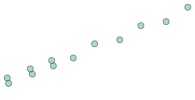

In [131]:
mp_moved = mov(*re.x,mp02)
mp_moved

In [132]:
df2_nums = list(zip(*df02['Num'].iteritems()))[1]
al = list(zip(df2_nums,mp_moved))
mov_stag = [[i[0],i[1].x,i[1].y,al[-1][1].distance(i[1])] for i in al]
mov_df = pd.DataFrame.from_records(mov_stag,columns=('Num','X','Y','Dist'))
mov_df

,Num,X,Y,Dist
0,609,-14508.085613,-446.117557,75.313632
1,608,-14486.660032,-431.841115,49.955337
2,610,-14529.792545,-448.635295,96.241950
3,611,-14549.225133,-462.265510,119.435671
4,612,-14574.382649,-466.186257,144.161730
5,610a,-14528.056404,-454.027120,96.753435
6,611a,-14551.228058,-457.041346,119.266772
7,612a,-14573.031527,-471.629786,144.996283
8,607,-14461.388582,-427.842827,25.570046
9,605,-14414.776804,-409.600672,25.691876


In [133]:
zz =  pd.concat([df01,mov_df.rename(columns={'Num':'Num'})]).fillna(0).groupby('Num', as_index=False).last()
zz

,Num,X,Y,Dist
0,593,-14133.887400,-299.583600,0.000000
1,594,-14159.244600,-303.605200,0.000000
2,595,-14180.551200,-317.862700,0.000000
3,596,-14205.796800,-321.824000,0.000000
4,597,-14227.175700,-336.142800,0.000000
5,597a,-14229.019800,-330.917400,0.000000
6,598,-14252.268910,-340.045658,51.162629
7,599,-14274.391879,-354.624764,25.844611
8,600,-14299.915662,-358.684370,0.000000
9,601,-14321.163836,-372.931709,25.582642


In [134]:
df01 = zz
df02 = pd.read_csv(r'data/chain/106.csv',sep=';', names=['Num','X','Y','Dist'],dtype={'Num':'str'})
inter = sorted(set(list(zip(*df01['Num'].iteritems()))[1]).intersection(set(list(zip(*df02['Num'].iteritems()))[1])))

df01_com = df01.loc[df01['Num'].isin(inter)].sort_values(by='Num')
df02_com = df02.loc[df02['Num'].isin(inter)].sort_values(by='Num')
mp01 = MultiPoint([i[2:4] for i in df01.itertuples()])
mp01_c = MultiPoint([i[2:4] for i in df01_com.itertuples()])
mp02 = MultiPoint([i[2:4] for i in df02.itertuples()])
mp02_c = MultiPoint([i[2:4] for i in df02_com.itertuples()])
x0 = (0,0,0)

re = minimize(fun1,x0,args=(mp01_c,mp02_c),method='SLSQP')
mp_moved = mov(*re.x,mp02)

In [137]:
re

     fun: 4.236177418337145
     jac: array([   1.99254447,   -0.40828776,  221.74558228,    0.        ])
 message: 'Iteration limit exceeded'
    nfev: 545
     nit: 101
    njev: 101
  status: 9
 success: False
       x: array([ -405.84391151,  3067.52073644,    12.65462041])

In [138]:
inter

['610', '610a', '611', '611a', '612', '612a']

In [136]:
df2_nums = list(zip(*df02['Num'].iteritems()))[1]
al = list(zip(df2_nums,mp_moved))
mov_stag = [[i[0],i[1].x,i[1].y,al[-1][1].distance(i[1])] for i in al]
mov_df = pd.DataFrame.from_records(mov_stag,columns=('Num','X','Y','Dist'))
mov_df

,Num,X,Y,Dist
0,612,-14574.506644,-465.178297,24.894722
1,611,-14549.211001,-462.285522,5.594790
2,613,-14596.914747,-478.751945,50.814175
3,614,-14620.621286,-481.361715,73.766592
4,615,-14643.239990,-494.780231,99.684099
5,613a,-14599.453386,-473.751012,51.273215
6,614a,-14619.703802,-486.664942,74.841707
7,615a,-14639.901496,-488.013992,94.161997
8,612a,-14573.378611,-470.672027,26.233544
9,610a,-14527.723964,-454.916681,23.366804


g